### Tensor Manipulations

In [1]:
from collections import namedtuple
import torch
import torch.nn as nn
import random
import cv2
import gym
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import skimage.transform as transforms

In [2]:
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward'))
transitions = [Transition(1,2,3,4),Transition(5,6,7,8)]
print(list(zip(*transitions)))
a=Transition(*zip(*transitions))
print(a)

[(1, 5), (2, 6), (3, 7), (4, 8)]
Transition(state=(1, 5), action=(2, 6), next_state=(3, 7), reward=(4, 8))


In [3]:
print(Transition(*[1,2,3,4]))
#print(Transition([1,2,3,4]))

Transition(state=1, action=2, next_state=3, reward=4)


In [4]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """save as a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
memory = ReplayMemory(100)
for i in range(100):
    memory.push(torch.tensor([[i]]),torch.tensor([[i]]),torch.tensor([[i]]),torch.tensor([[i]]))
transitions = memory.sample(3)
batch = Transition(*zip(*transitions))
#print(batch)
state_batch = torch.cat(batch.state)
print(batch.state)
print(state_batch)

(tensor([[57]]), tensor([[51]]), tensor([[97]]))
tensor([[57],
        [51],
        [97]])


In [6]:
memory = ReplayMemory(100)
memory.push(torch.tensor([[i]]),torch.tensor([[i]]), None, torch.tensor([[i]]))
print(memory.memory)

[Transition(state=tensor([[99]]), action=tensor([[99]]), next_state=None, reward=tensor([[99]]))]


In [7]:
print(batch.next_state)
non_terminal = torch.cat([s for s in batch.next_state if s is not None])
print(non_terminal)

(tensor([[57]]), tensor([[51]]), tensor([[97]]))
tensor([[57],
        [51],
        [97]])


In [8]:
non_terminal_mask = torch.tensor(tuple(map(lambda s: s.item() is not 12,
                                        batch.next_state)), device='cpu', 
                                        dtype=torch.bool)
print(non_terminal_mask)

tensor([True, True, True])


In [9]:
non_terminal[non_terminal_mask]

tensor([[57],
        [51],
        [97]])

In [10]:
# c = torch.zeros((3,1))
# c[[False, True, True]] = b
# print(c)
# c = torch.zeros((3,1))
# c[non_terminal_mask] = b    #to show non_termial_mask is a list of bool numbers
# print(c)

In [11]:
a = torch.randn(1,2,2)
b = torch.randn(1,2,2)
c = torch.cat((a,b))
print(c)
d, _ = c.max(dim=0)
print(d)

tensor([[[-1.7181, -0.6962],
         [ 0.2353, -1.2120]],

        [[ 0.5682,  1.1439],
         [ 0.1395,  1.2377]]])
tensor([[0.5682, 1.1439],
        [0.2353, 1.2377]])


torch.float32 0.0 False


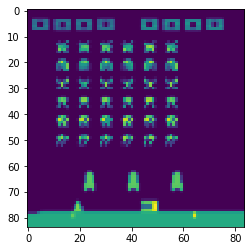

In [12]:
env = gym.make('SpaceInvaders-v0')
obs = env.reset()
device = 'cpu'
num_frames = 4
total_reward = 0
state = torch.zeros((num_frames, 84, 84))
obs_buffer = np.zeros((2, ) + env.observation_space.shape, dtype=np.uint8)
action = env.action_space.sample()
obs, reward, done, info = env.step(action)
obs_buffer[0] = obs
for i in range(num_frames):
    obs, reward, done, info = env.step(action)
    obs_buffer[1] = obs
    total_reward += reward
    max_frame = transforms.resize(obs_buffer.max(axis=0), (84, 84))
    state[i] = torch.from_numpy(color.rgb2gray(max_frame)).float().to(device) #(84, 84)
    if done:
        env.reset()
        break
    obs_buffer[0] = obs
print(state.unsqueeze(0).dtype, total_reward, done)
plt.imshow(state.permute(1,2,0)[:,:,0])

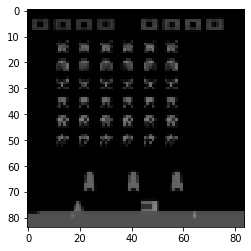

In [13]:
plt.imshow(state.permute(1,2,0)[:,:,:-1])

#### CartPole DQN

In [14]:
env = gym.make('CartPole-v0')
obs = env.reset()
print(torch.from_numpy(obs).unsqueeze(0).shape)

torch.Size([1, 4])


In [15]:
class FcDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc_net = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_dim)
        )

    def forward(self, observation):
        qvals = self.fc_net(observation.view(-1, self.input_dim))
        return qvals
model = FcDQN(4,2)
x = torch.ones((10,4))
y = model(x)
print(y.shape)

torch.Size([10, 2])


In [16]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bounds, offset):
        super(Actor, self).__init__()
        # actor
        self.actor = nn.Sequential(
                        nn.Linear(state_dim + state_dim, 64),
                        nn.ReLU(),
                        nn.Linear(64, 64),
                        nn.ReLU(),
                        nn.Linear(64, action_dim),
                        nn.Tanh()
                        )
        # max value of actions
        self.action_bounds = action_bounds
        self.offset = offset
        
    def forward(self, state, goal):
        return (self.actor(torch.cat([state, goal], 1)) * self.action_bounds) + self.offset

In [21]:
actor = Actor(2,2,1,0)
a = actor(torch.ones(2,2), torch.ones(2,2)).detach().data.numpy().flatten()
print(a.shape)

(4,)


In [9]:
class ConvDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        #if feature_dim = 6272, input_batch / 2 = output_batch
        self.feature_dim = 3136

        self.conv_net = nn.Sequential(
            nn.Conv2d(self.input_dim, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
            )

        self.fc_net = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_dim)
            )

    def forward(self, observation):
        features = self.conv_net(observation)
        qvals = self.fc_net(features.view(-1, self.feature_dim))
        return qvals

In [12]:
model = ConvDQN(3, 10)
state = torch.ones(18, 3, 84, 84)
output = model(state)
print(output.shape)

torch.Size([18, 10])
